In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../..")

In [3]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

logging.basicConfig(level=logging.INFO)

In [4]:
dataset = "mnist"
algo = "modular"

experiment_folder = "experiment_results"
experiment_name = "vanilla_fix_bug_compute_loss_encodev2"

use_contrastive = True
num_trains_per_class = 64
seed = 0
num_tasks = 10
parallel = False
comm_freq = 2 # "None" means no communication, doesn't matter for this analysis


save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)


In [5]:
def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    # cfg.sharing_strategy["sync_base"] = False

    module_selection_strategy = 'gt_most_similar'

    cfg.sharing_strategy = DictConfig({
        "name": "modmod",
        'num_coms_per_round': 2,
        'module_selection': module_selection_strategy,
        'sync_base': False,
        'opt_with_random': None,
    })
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

In [6]:
def add_random_module(receiver, task_id, check=True):
    if check and len(receiver.net.candidate_indices) != 0:
        return
    receiver.net.add_tmp_modules(task_id, num_modules=1)

def transfer_module(receiver, sender, task_id, check=True):
    new_module = sender.net.components[-1]
    add_random_module(receiver, task_id, check=check)
    receiver.net.receive_modules(task_id, [new_module])

def transfer_decoder(receiver, sender, rcv_task_id, sender_task_id=None):
    if sender_task_id is None:
        sender_task_id = rcv_task_id
    receiver.net.decoder[rcv_task_id].load_state_dict(sender.net.decoder[sender_task_id].state_dict())

@torch.no_grad()
def transfer_structure(receiver, sender, task_id):
    target = receiver.net.structure[task_id]
    source = sender.net.structure[task_id]
    if target.shape == source.shape:
        target.copy_(source)

In [7]:
def run_counterfactual_scenario(scenario, task_id=None, agent_id=None, parallel=False):
    total_results = defaultdict(dict)
    dummy = setup_fleet(save_dir, parallel=parallel, modify_cfg=modify_cfg)
    task_ids = range(dummy.num_init_tasks, num_tasks) if task_id is None else [task_id]
    agent_ids = range(len(dummy.agents)) if agent_id is None else [agent_id]

    for t_id in task_ids:
        print('task', t_id)
        target_fleet = setup_fleet(save_dir, t_id-1, parallel=parallel, modify_cfg=modify_cfg)
        source_fleet = setup_fleet(save_dir, t_id, parallel=parallel, modify_cfg=modify_cfg)
        for a_id in agent_ids:
            print('a_id', a_id)
            target_agent = target_fleet.agents[a_id]
            source_agent = source_fleet.agents[a_id] 

            results = {'Raw': None, 'Transfer Decoder': None, 'Decoder + Structure': None}

            if scenario == "no new module":
                pass
            elif scenario == "optimized module":
                transfer_module(target_agent, source_agent, t_id)
            elif scenario == "random module":
                add_random_module(target_agent, t_id)

            results['Raw'] = target_agent.eval_test(t_id)
            
            transfer_decoder(target_agent, source_agent, t_id)
            results['Transfer Decoder'] = target_agent.eval_test(t_id)

            transfer_structure(target_agent, source_agent, t_id)
            results['Decoder + Structure'] = target_agent.eval_test(t_id)

            total_results[t_id][a_id] = results

    return total_results


In [8]:
def run_opt_module_struct(scenario, target_agent, source_agent, task_id, train_candidate_module=True):
    if "optimized_module" in scenario:
        transfer_module(target_agent, source_agent, task_id)
        train_candidate_module = False if "frozen" in scenario else True
    elif scenario == "random_module":
        add_random_module(target_agent, task_id)
        train_candidate_module = True
    else:
        raise NotImplementedError

    target_agent.agent.T = task_id
    target_agent.update_replay_buffer(task_id-1)
    target_agent.agent.change_save_dir(target_agent.agent.save_dir.replace(experiment_name, experiment_name + "_modmod_eng_" + scenario))
    # opt the last component
    # target_agent.net.active_candidate_index = target_agent.net.num_components-1
    # target_agent.net.candidate_indices = [target_agent.net.num_components-1]
    # print(target_agent.net.candidate_indices, target_agent.net.active_candidate_index)

    target_agent.train(task_id, train_candidate_module=train_candidate_module,
                       save_freq=10,
                       num_candidate_modules=0,)
    return target_agent

In [9]:
def run_training_scenario(scenario, task_id, agent_id, parallel=False):
    target_fleet = setup_fleet(save_dir, task_id-1, parallel=parallel, modify_cfg=modify_cfg)
    target_agent = target_fleet.agents[agent_id]

    source_fleet = setup_fleet(save_dir, task_id, parallel=parallel, modify_cfg=modify_cfg)
    source_agent = source_fleet.agents[agent_id] 
    return run_opt_module_struct(scenario, target_agent, source_agent, task_id)

In [10]:
def run_learning_speed_scenario(scenario, source_agent_id, target_agent_id,
                                source_task, target_task, parallel=False):
    fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=parallel)
    source_agent = fleet.agents[source_agent_id]
    target_agent = fleet.agents[target_agent_id]

    source_agent.load_model_from_ckpoint(task_id=source_task)
    target_agent.load_model_from_ckpoint(task_id=target_task-1)
    return run_opt_module_struct(scenario, target_agent, source_agent, target_task)

## Counterfactual
Same exact model

### Zero-shot Transfer

In [ ]:

def plot_performance(res):
    categories = ['Raw', 'Transfer Decoder', 'Decoder + Structure']
    task_ids = sorted(res.keys())
    means = {category: [] for category in categories}
    stds = {category: [] for category in categories}

    for t_id in task_ids:
        for category in categories:
            scores = [res[t_id][a_id][category][t_id] for a_id in res[t_id]]
            means[category].append(np.mean(scores))
            stds[category].append(np.std(scores))

    plt.figure(figsize=(10, 6))
    for category in categories:
        mean_scores = means[category]
        std_scores = stds[category]
        plt.plot(task_ids, mean_scores, label=category)
        plt.fill_between(task_ids, np.subtract(mean_scores, std_scores), np.add(mean_scores, std_scores), alpha=0.2)

    plt.xlabel('Task ID')
    plt.ylabel('Average Performance')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
res = run_counterfactual_scenario("no new module")

In [ ]:
plot_performance(res)

In [ ]:
res = run_counterfactual_scenario("optimized module")
plot_performance(res)

In [ ]:
res = run_counterfactual_scenario("random module")
plot_performance(res)

### Learning speed
Only transfer the module. Receiver optimized the structure and decoder on its own.

In [37]:
target_agent = run_training_scenario("optimized_module_frozen", task_id=4, agent_id=0)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69841486	acc: 0.498
INFO:root:	task: avg	loss: 0.44113932	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69539884	acc: 0.498
INFO:root:	task: avg	loss: 0.44053611	acc: 0.879
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69361331	acc: 0.502
INFO:root:	task: avg	loss: 0.44017901	acc: 0.880
INFO:root:epochs: 21, training ta

In [38]:
random_module_target_agent = run_training_scenario("random_module", task_id=4, agent_id=0)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69317988	acc: 0.498
INFO:root:	task: avg	loss: 0.44009232	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69314880	acc: 0.498
INFO:root:	task: avg	loss: 0.44008611	acc: 0.879
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69669977	acc: 0.502
INFO:root:	task: avg	loss: 0.44079630	acc: 0.880
INFO:root:epochs: 21, training ta

In [39]:
unfrozen_target_agent = run_training_scenario("optimized_module", task_id=4, agent_id=0)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69841486	acc: 0.498
INFO:root:	task: avg	loss: 0.44113932	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69575993	acc: 0.498
INFO:root:	task: avg	loss: 0.44060833	acc: 0.879
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69351377	acc: 0.865
INFO:root:	task: avg	loss: 0.44015910	acc: 0.952
INFO:root:epochs: 21, training ta

In [40]:
df = target_agent.agent.record.df
unfrozen_df = unfrozen_target_agent.agent.record.df
random_module_df = random_module_target_agent.agent.record.df

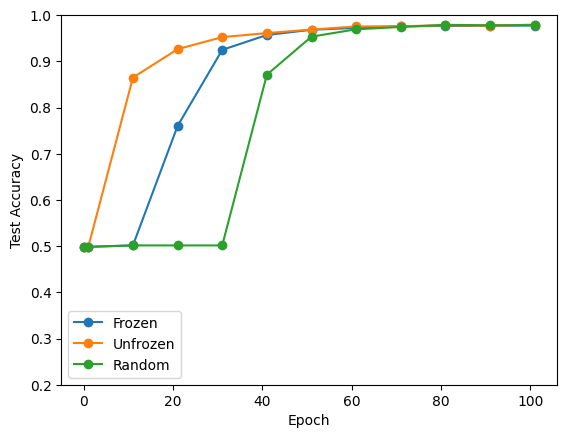

In [41]:
# plot test_task with epoch
test_task = 4
fig, ax = plt.subplots()
df[df['test_task'] == test_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
unfrozen_df[unfrozen_df['test_task'] == test_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                               label="Unfrozen",
                                                                                                               marker='o')

random_module_df[random_module_df['test_task'] == test_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);

## Task Similarity between neighbors

In [53]:
fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)


INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [2 8 0 3 7 4 3 4 4 5 9 3 0 6 9 1 3 1 7 9]
INFO:root:task 0 :(128, 1,

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


In [54]:
source_agent_id, target_agent_id = 0, 2
source_task, target_task = 4, 7
source_agent = fleet.agents[source_agent_id]
target_agent = fleet.agents[target_agent_id]

In [55]:
fleet.load_records()
fleet.load_model_from_ckpoint(task_ids=target_task)

In [56]:
fleet.communicate_round(target_task, end_epoch=-1, comm_freq=-1, num_epochs=-1,
                        communication_round=0)

In [57]:
for agent in fleet.agents:
    print(agent.dataset.class_sequence[:(target_task + 1)* agent.dataset.num_classes_per_task])

[5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4]
[4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7]
[6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0]
[2 8 0 3 7 4 3 4 4 5 9 3 0 6 9 1]
[0 3 0 2 9 7 0 9 2 1 7 6 8 6 1 8]
[8 4 6 3 3 1 1 6 4 9 3 2 2 9 6 0]
[7 5 8 4 6 9 8 3 4 6 1 3 3 1 4 1]
[5 1 8 3 9 6 5 9 5 0 7 2 7 8 6 1]


In [58]:
fleet.communicate_round(target_task, end_epoch=-1, comm_freq=-1, num_epochs=-1,
                        communication_round=1)

In [59]:
target_agent.incoming_modules

{0: [(4, 1.0, Linear(in_features=64, out_features=64, bias=True))],
 1: [(4,
   0.3333333333333333,
   Linear(in_features=64, out_features=64, bias=True))],
 3: [(6,
   0.3333333333333333,
   Linear(in_features=64, out_features=64, bias=True))],
 4: [(7,
   0.3333333333333333,
   Linear(in_features=64, out_features=64, bias=True))],
 5: [(7,
   0.3333333333333333,
   Linear(in_features=64, out_features=64, bias=True))],
 6: [],
 7: [(4,
   0.3333333333333333,
   Linear(in_features=64, out_features=64, bias=True))]}

In [60]:
target_agent.train_kwargs

{'component_update_freq': 100,
 'num_epochs': 100,
 'init_component_update_freq': 100,
 'init_num_epochs': 100,
 'save_freq': 20,
 'module_list': [Linear(in_features=64, out_features=64, bias=True)]}

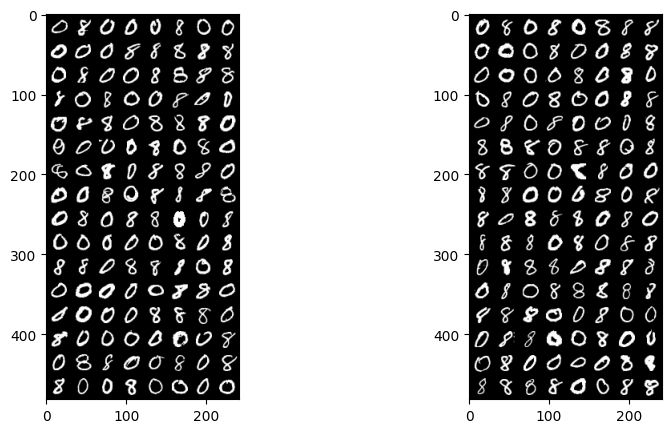

In [61]:
# make sure that they have the same tasks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(make_grid(source_agent.dataset.trainset[source_task].tensors[0]).permute(1, 2, 0))
ax[1].imshow(make_grid(target_agent.dataset.trainset[target_task].tensors[0]).permute(1, 2, 0))

In [62]:

add_modules_record = os.path.join(
    source_agent.save_dir, "add_modules_record.csv")
df = pd.read_csv(add_modules_record)
df

,task_id,best_candidate_idx,best_improvement,num_components,add_new_module
0,4,4,1.106383,5,True
1,5,5,0.010101,5,False
2,6,5,0.507937,6,True
3,7,6,0.280000,7,True
4,8,7,0.010309,7,False
5,9,7,0.089888,8,True


In [63]:

add_modules_record = os.path.join(
    target_agent.save_dir, "add_modules_record.csv")
df = pd.read_csv(add_modules_record)
df

,task_id,best_candidate_idx,best_improvement,num_components,add_new_module
0,4,4,1.309524,5,True
1,5,5,0.590164,6,True
2,6,6,0.156627,7,True
3,7,7,0.054348,8,True
4,8,8,0.491525,9,True
5,9,9,0.010638,9,False


In [65]:
fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)

source_agent_id, target_agent_id = 0, 2
source_task, target_task = 4, 7
source_agent = fleet.agents[source_agent_id]
target_agent = fleet.agents[target_agent_id]

source_agent.load_model_from_ckpoint(task_id=source_task)
target_agent.load_model_from_ckpoint(task_id=target_task-1)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [2 8 0 3 7 4 3 4 4 5 9 3 0 6 9 1 3 1 7 9]
INFO:root:task 0 :(128, 1,

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


In [66]:
target_agent.eval_test(target_task)

{0: 0.972809667673716,
 1: 0.955044955044955,
 2: 0.9914974019839395,
 3: 0.9848269321953532,
 4: 0.9875776397515528,
 5: 0.9649484536082474,
 6: 0.9630208333333333,
 7: 0.6944728761514841,
 'avg': 0.9392748449678227}

In [ ]:
# transfer_decoder(target_agent, source_agent, target_task, source_task)
# target_agent.eval_test(target_task)
'''
{0: 0.9615384615384616,
 1: 0.9839357429718876,
 2: 0.9695876288659794,
 3: 0.9809236947791165,
 4: 0.4984646878198567,
 'avg': 0.8788900431950604}
 '''

In [ ]:
# transfer_module(target_agent, source_agent, target_task)
# target_agent.eval_test(target_task)
'''
{0: 0.9615384615384616,
 1: 0.9839357429718876,
 2: 0.9695876288659794,
 3: 0.9809236947791165,
 4: 0.4984646878198567,
 'avg': 0.8788900431950604}
 '''

In [77]:
random_module_target_agent = run_learning_speed_scenario("random_module", source_agent_id, target_agent_id,
                                source_task, target_task)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [2 8 0 3 7 4 3 4 4 5 9 3 0 6 9 1 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.26840176	acc: 0.963
INFO:root:	task: 7	loss: 0.68876228	acc: 0.694
INFO:root:	task: avg	loss: 0.37125180	acc: 0.939
INFO:root:epochs: 1, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.27033662	acc: 0.963
INFO:root:	task: 7	loss: 0.68784597	acc: 0.498
INFO:root:	task: avg	loss: 0.37137912	acc: 0.915
INFO:root:epochs: 11, training task: 7
INFO:root:	task: 0	loss: 0.38765956

In [78]:
# unfrozen_mod_target_agent = run_learning_speed_scenario("optimized_module", source_agent_id, target_agent_id,
#                                 source_task, target_task)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.47406288	acc: 0.855
INFO:root:	task: 7	loss: 0.68922446	acc: 0.498
INFO:root:	task: avg	loss: 0.39701721	acc: 0.901
INFO:root:epochs: 1, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.47380759	acc: 0.851
INFO:root:	task: 7	loss: 0.68772553	acc: 0.498
INFO:root:	task: avg	loss: 0.39679793	acc: 0.901
INFO:root:epochs: 11, training task: 7
INFO:root:	task: 0	loss: 0.38765956

In [79]:
# frozen_mod_target_agent = run_learning_speed_scenario("optimized_module_frozen", source_agent_id, target_agent_id,
#                                 source_task, target_task)

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.47406288	acc: 0.855
INFO:root:	task: 7	loss: 0.68922446	acc: 0.498
INFO:root:	task: avg	loss: 0.39701721	acc: 0.901
INFO:root:epochs: 1, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.47406288	acc: 0.855
INFO:root:	task: 7	loss: 0.68838930	acc: 0.498
INFO:root:	task: avg	loss: 0.39691282	acc: 0.901
INFO:root:epochs: 11, training task: 7
INFO:root:	task: 0	loss: 0.38765956

In [80]:
# df = frozen_mod_target_agent.agent.record.df
# unfrozen_df = unfrozen_mod_target_agent.agent.record.df
# random_module_df = random_module_target_agent.agent.record.df

In [81]:
# frozen_mod_target_agent.agent.record.df

,train_task,test_task,test_acc,test_loss,epoch
0,7,0,0.972810,0.387660,0
0,7,1,0.955045,0.366619,0
0,7,2,0.991497,0.372991,0
0,7,3,0.984827,0.369828,0
0,7,4,0.987578,0.251642,0
...,...,...,...,...,...
0,7,4,0.989011,0.230265,101
0,7,5,0.965464,0.248995,101
0,7,6,0.768750,0.460213,101
0,7,7,0.875128,0.348122,101


INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


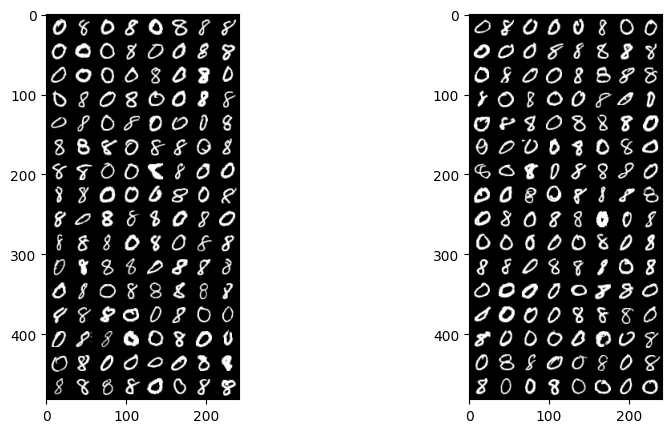

In [14]:
fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)
# source_agent_id, target_agent_id = 0, 2
# source_task, target_task = 4, 7

source_agent_id, target_agent_id = 2, 0
source_task, target_task = 7, 4

source_agent = fleet.agents[source_agent_id]
target_agent = fleet.agents[target_agent_id]
# make sure that they have the same tasks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(make_grid(source_agent.dataset.trainset[source_task].tensors[0]).permute(1, 2, 0))
ax[1].imshow(make_grid(target_agent.dataset.trainset[target_task].tensors[0]).permute(1, 2, 0))

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69336584	acc: 0.498
INFO:root:	task: avg	loss: 0.44012952	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69322095	acc: 0.500
INFO:root:	task: avg	loss: 0.44010054	acc: 0.879
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69779419	acc: 0.502
INFO:root:	task: avg	loss: 0.44101519	acc: 0.880
INFO:root:epochs: 21, training ta

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69261886	acc: 0.498
INFO:root:	task: avg	loss: 0.43998012	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69314424	acc: 0.502
INFO:root:	task: avg	loss: 0.44008520	acc: 0.880
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69597433	acc: 0.502
INFO:root:	task: avg	loss: 0.44065121	acc: 0.880
INFO:root:epochs: 21, training ta

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69261886	acc: 0.498
INFO:root:	task: avg	loss: 0.43998012	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69314452	acc: 0.502
INFO:root:	task: avg	loss: 0.44008525	acc: 0.880
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69814362	acc: 0.502
INFO:root:	task: avg	loss: 0.44108507	acc: 0.880
INFO:root:epochs: 21, training ta

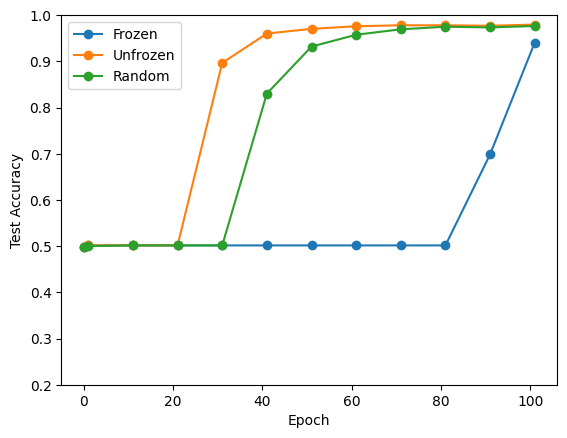

In [15]:
random_module_target_agent = run_learning_speed_scenario("random_module", source_agent_id, target_agent_id,
                                source_task, target_task)
unfrozen_mod_target_agent = run_learning_speed_scenario("optimized_module", source_agent_id, target_agent_id,
                                source_task, target_task)
frozen_mod_target_agent = run_learning_speed_scenario("optimized_module_frozen", source_agent_id, target_agent_id,
                                source_task, target_task)
df = frozen_mod_target_agent.agent.record.df
unfrozen_df = unfrozen_mod_target_agent.agent.record.df
random_module_df = random_module_target_agent.agent.record.df


# plot test_task with epoch
fig, ax = plt.subplots()
df[df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
unfrozen_df[unfrozen_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                               label="Unfrozen",
                                                                                                               marker='o')

random_module_df[random_module_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);

Very interesting phenomenon when reversing the transfer direction. Probably the coordination between the agents is the determining factor.

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


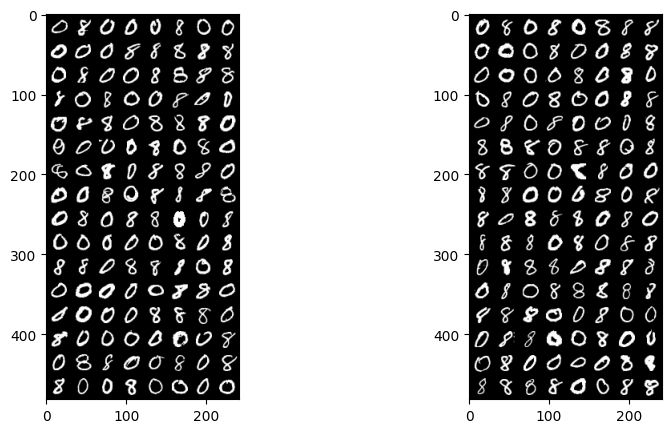

In [16]:
fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)
source_agent_id, target_agent_id = 0, 2
source_task, target_task = 4, 7

# source_agent_id, target_agent_id = 2, 0
# source_task, target_task = 7, 4

source_agent = fleet.agents[source_agent_id]
target_agent = fleet.agents[target_agent_id]
# make sure that they have the same tasks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(make_grid(source_agent.dataset.trainset[source_task].tensors[0]).permute(1, 2, 0))
ax[1].imshow(make_grid(target_agent.dataset.trainset[target_task].tensors[0]).permute(1, 2, 0))

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.26840176	acc: 0.963
INFO:root:	task: 7	loss: 0.68876228	acc: 0.694
INFO:root:	task: avg	loss: 0.37125180	acc: 0.939
INFO:root:epochs: 1, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.27033662	acc: 0.963
INFO:root:	task: 7	loss: 0.68784597	acc: 0.498
INFO:root:	task: avg	loss: 0.37137912	acc: 0.915
INFO:root:epochs: 11, training task: 7
INFO:root:	task: 0	loss: 0.38765956

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.47406288	acc: 0.855
INFO:root:	task: 7	loss: 0.68922446	acc: 0.498
INFO:root:	task: avg	loss: 0.39701721	acc: 0.901
INFO:root:epochs: 1, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.47380759	acc: 0.851
INFO:root:	task: 7	loss: 0.68772553	acc: 0.498
INFO:root:	task: avg	loss: 0.39679793	acc: 0.901
INFO:root:epochs: 11, training task: 7
INFO:root:	task: 0	loss: 0.38765956

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.47406288	acc: 0.855
INFO:root:	task: 7	loss: 0.68922446	acc: 0.498
INFO:root:	task: avg	loss: 0.39701721	acc: 0.901
INFO:root:epochs: 1, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.47406288	acc: 0.855
INFO:root:	task: 7	loss: 0.68838930	acc: 0.498
INFO:root:	task: avg	loss: 0.39691282	acc: 0.901
INFO:root:epochs: 11, training task: 7
INFO:root:	task: 0	loss: 0.38765956

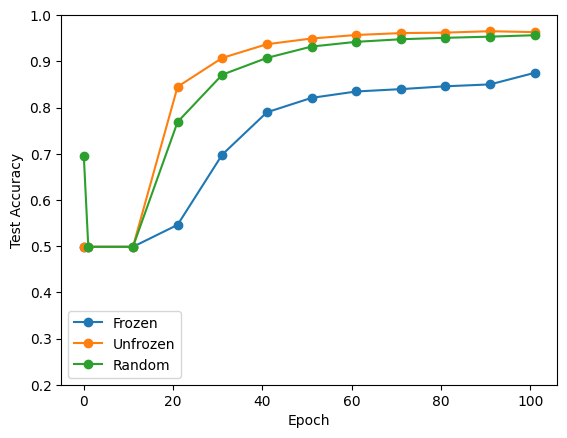

In [17]:
random_module_target_agent = run_learning_speed_scenario("random_module", source_agent_id, target_agent_id,
                                source_task, target_task)
unfrozen_mod_target_agent = run_learning_speed_scenario("optimized_module", source_agent_id, target_agent_id,
                                source_task, target_task)
frozen_mod_target_agent = run_learning_speed_scenario("optimized_module_frozen", source_agent_id, target_agent_id,
                                source_task, target_task)
df = frozen_mod_target_agent.agent.record.df
unfrozen_df = unfrozen_mod_target_agent.agent.record.df
random_module_df = random_module_target_agent.agent.record.df


# plot test_task with epoch
fig, ax = plt.subplots()
df[df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
unfrozen_df[unfrozen_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                               label="Unfrozen",
                                                                                                               marker='o')

random_module_df[random_module_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);

Two tasks have something in common but not completely identical

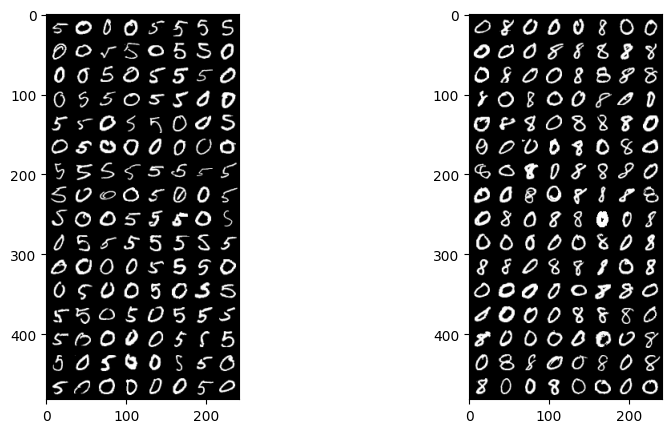

In [83]:
fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)
source_agent_id, target_agent_id = 1, 0
source_task, target_task = 4, 4
source_agent = fleet.agents[source_agent_id]
target_agent = fleet.agents[target_agent_id]
# make sure that they have the same tasks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(make_grid(source_agent.dataset.trainset[source_task].tensors[0]).permute(1, 2, 0))
ax[1].imshow(make_grid(target_agent.dataset.trainset[target_task].tensors[0]).permute(1, 2, 0))

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69336650	acc: 0.498
INFO:root:	task: avg	loss: 0.44012965	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69324597	acc: 0.499
INFO:root:	task: avg	loss: 0.44010554	acc: 0.879
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69652407	acc: 0.502
INFO:root:	task: avg	loss: 0.44076116	acc: 0.880
INFO:root:epochs: 21, training ta

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [2 8 0 3 7 4 3 4 4 5 9 3 0 6 9 1 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69414509	acc: 0.498
INFO:root:	task: avg	loss: 0.44028537	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69398325	acc: 0.499
INFO:root:	task: avg	loss: 0.44025300	acc: 0.879
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69496729	acc: 0.502
INFO:root:	task: avg	loss: 0.44044980	acc: 0.880
INFO:root:epochs: 21, training ta

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69414509	acc: 0.498
INFO:root:	task: avg	loss: 0.44028537	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69376160	acc: 0.500
INFO:root:	task: avg	loss: 0.44020867	acc: 0.879
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69517838	acc: 0.502
INFO:root:	task: avg	loss: 0.44049202	acc: 0.880
INFO:root:epochs: 21, training ta

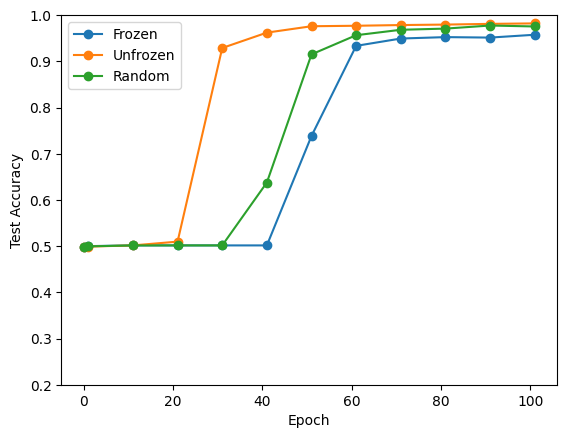

In [84]:
random_module_target_agent = run_learning_speed_scenario("random_module", source_agent_id, target_agent_id,
                                source_task, target_task)
unfrozen_mod_target_agent = run_learning_speed_scenario("optimized_module", source_agent_id, target_agent_id,
                                source_task, target_task)
frozen_mod_target_agent = run_learning_speed_scenario("optimized_module_frozen", source_agent_id, target_agent_id,
                                source_task, target_task)
df = frozen_mod_target_agent.agent.record.df
unfrozen_df = unfrozen_mod_target_agent.agent.record.df
random_module_df = random_module_target_agent.agent.record.df

# plot test_task with epoch
fig, ax = plt.subplots()
df[df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
unfrozen_df[unfrozen_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                               label="Unfrozen",
                                                                                                               marker='o')

random_module_df[random_module_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);

Source and target tasks have nothing in common

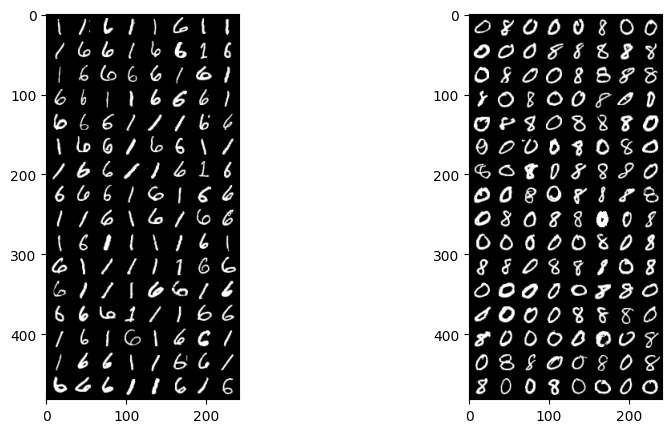

In [85]:
source_agent_id, target_agent_id = 2, 0
source_task, target_task = 4, 4
source_agent = fleet.agents[source_agent_id]
target_agent = fleet.agents[target_agent_id]
# make sure that they have the same tasks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(make_grid(source_agent.dataset.trainset[source_task].tensors[0]).permute(1, 2, 0))
ax[1].imshow(make_grid(target_agent.dataset.trainset[target_task].tensors[0]).permute(1, 2, 0))

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [2 8 0 3 7 4 3 4 4 5 9 3 0 6 9 1 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69336650	acc: 0.498
INFO:root:	task: avg	loss: 0.44012965	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69324597	acc: 0.499
INFO:root:	task: avg	loss: 0.44010554	acc: 0.879
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69652407	acc: 0.502
INFO:root:	task: avg	loss: 0.44076116	acc: 0.880
INFO:root:epochs: 21, training ta

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [2 8 0 3 7 4 3 4 4 5 9 3 0 6 9 1 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69356588	acc: 0.498
INFO:root:	task: avg	loss: 0.44016952	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69328667	acc: 0.515
INFO:root:	task: avg	loss: 0.44011368	acc: 0.882
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69503565	acc: 0.502
INFO:root:	task: avg	loss: 0.44046348	acc: 0.880
INFO:root:epochs: 21, training ta

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [2 8 0 3 7 4 3 4 4 5 9 3 0 6 9 1 3 1 7 9]
INFO:root:task 0 :(128, 1,

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69356588	acc: 0.498
INFO:root:	task: avg	loss: 0.44016952	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69319998	acc: 0.508
INFO:root:	task: avg	loss: 0.44009634	acc: 0.881
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69524619	acc: 0.502
INFO:root:	task: avg	loss: 0.44050559	acc: 0.880
INFO:root:epochs: 21, training ta

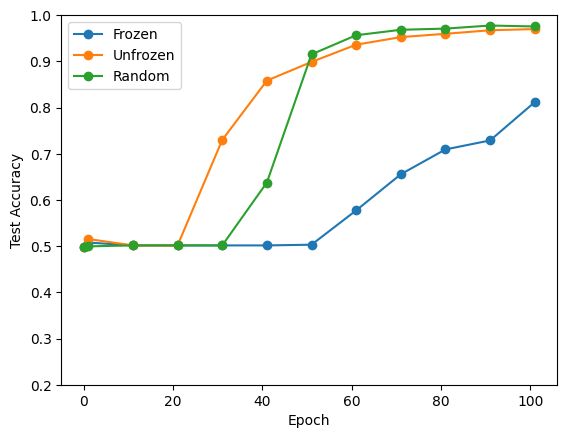

In [86]:
random_module_target_agent = run_learning_speed_scenario("random_module", source_agent_id, target_agent_id,
                                source_task, target_task)
unfrozen_mod_target_agent = run_learning_speed_scenario("optimized_module", source_agent_id, target_agent_id,
                                source_task, target_task)
frozen_mod_target_agent = run_learning_speed_scenario("optimized_module_frozen", source_agent_id, target_agent_id,
                                source_task, target_task)
df = frozen_mod_target_agent.agent.record.df
unfrozen_df = unfrozen_mod_target_agent.agent.record.df
random_module_df = random_module_target_agent.agent.record.df

# plot test_task with epoch
fig, ax = plt.subplots()
df[df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
unfrozen_df[unfrozen_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                               label="Unfrozen",
                                                                                                               marker='o')

random_module_df[random_module_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);

## Testing the engineering of the modmod fleet

In [31]:
source_agent_id, target_agent_id = 0, 2
source_task, target_task = 4, 7

fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False, task_id=target_task-1)
fleet.load_records()

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)


INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


In [32]:
target_agent = fleet.agents[target_agent_id]
target_agent.eval_test(target_task)

{0: 0.972809667673716,
 1: 0.955044955044955,
 2: 0.9914974019839395,
 3: 0.9848269321953532,
 4: 0.9875776397515528,
 5: 0.9649484536082474,
 6: 0.9630208333333333,
 7: 0.6944728761514841,
 'avg': 0.9392748449678227}

In [38]:
fleet.communicate_round(target_task, end_epoch=-1, comm_freq=-1, num_epochs=-1,
                        communication_round=0)

fleet.communicate_round(target_task, end_epoch=-1, comm_freq=-1, num_epochs=-1,
                        communication_round=1)

node 0 for neighbor 1 @ task 7 sending module 6 from task 7 with similarity 0.3333333333333333 current no. of modules 6
node 0 for neighbor 2 @ task 7 sending module 4 from task 4 with similarity 1.0 current no. of modules 6
node 0 for neighbor 3 @ task 7 sending module 5 from task 6 with similarity 0.3333333333333333 current no. of modules 6
node 0 for neighbor 4 @ task 7 sending module 4 from task 4 with similarity 0.3333333333333333 current no. of modules 6
node 0 for neighbor 5 @ task 7 sending module 6 from task 7 with similarity 0.3333333333333333 current no. of modules 6
node 0 for neighbor 6 @ task 7 sending module 6 from task 7 with similarity 0.3333333333333333 current no. of modules 6
node 0 for neighbor 7 @ task 7 sending module 6 from task 7 with similarity 0.3333333333333333 current no. of modules 6
node 1 for neighbor 0 @ task 7 sending module 5 from task 5 with similarity 0.3333333333333333 current no. of modules 7
node 1 for neighbor 2 @ task 7 sending module 4 from ta

In [40]:
target_agent.incoming_modules

{0: [(4, 1.0, Linear(in_features=64, out_features=64, bias=True))],
 1: [(4,
   0.3333333333333333,
   Linear(in_features=64, out_features=64, bias=True))],
 3: [(6,
   0.3333333333333333,
   Linear(in_features=64, out_features=64, bias=True))],
 4: [],
 5: [],
 6: [],
 7: [(4,
   0.3333333333333333,
   Linear(in_features=64, out_features=64, bias=True))]}

In [47]:
target_agent.incoming_modules[0][0][-1].bias

Parameter containing:
tensor([-0.0646, -0.0702, -0.0162,  0.1317,  0.1467, -0.0240,  0.0990, -0.0784,
         0.0353,  0.0789,  0.1237,  0.0669,  0.0409,  0.0143,  0.0636,  0.0092,
         0.0520,  0.0068, -0.0102,  0.1408,  0.1123,  0.1155,  0.1046,  0.2151,
         0.0566, -0.0409,  0.1087, -0.0184,  0.1858,  0.2269, -0.1274, -0.0185,
         0.2065,  0.1053,  0.0364,  0.0746, -0.0502, -0.1209,  0.0950,  0.1095,
         0.1376, -0.0241,  0.1893,  0.1669,  0.1146,  0.1216, -0.0206,  0.2147,
         0.2897,  0.1106,  0.0124,  0.1987,  0.1893,  0.0413,  0.0875,  0.1126,
         0.2308,  0.2243,  0.2218,  0.0792, -0.0119,  0.0798,  0.1917,  0.0926],
       device='cuda:0', requires_grad=True)

In [44]:
target_agent.train_kwargs['module_list'][0].bias

Parameter containing:
tensor([-0.0646, -0.0702, -0.0162,  0.1317,  0.1467, -0.0240,  0.0990, -0.0784,
         0.0353,  0.0789,  0.1237,  0.0669,  0.0409,  0.0143,  0.0636,  0.0092,
         0.0520,  0.0068, -0.0102,  0.1408,  0.1123,  0.1155,  0.1046,  0.2151,
         0.0566, -0.0409,  0.1087, -0.0184,  0.1858,  0.2269, -0.1274, -0.0185,
         0.2065,  0.1053,  0.0364,  0.0746, -0.0502, -0.1209,  0.0950,  0.1095,
         0.1376, -0.0241,  0.1893,  0.1669,  0.1146,  0.1216, -0.0206,  0.2147,
         0.2897,  0.1106,  0.0124,  0.1987,  0.1893,  0.0413,  0.0875,  0.1126,
         0.2308,  0.2243,  0.2218,  0.0792, -0.0119,  0.0798,  0.1917,  0.0926],
       device='cuda:0', requires_grad=True)

In [48]:
target_agent.train(target_task)

INFO:root:epochs: 0, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.26840176	acc: 0.963
INFO:root:	task: 7	loss: 0.68876228	acc: 0.694
INFO:root:	task: avg	loss: 0.37125180	acc: 0.939
INFO:root:epochs: 1, training task: 7
INFO:root:	task: 0	loss: 0.38765956	acc: 0.973
INFO:root:	task: 1	loss: 0.36661929	acc: 0.955
INFO:root:	task: 2	loss: 0.37299132	acc: 0.991
INFO:root:	task: 3	loss: 0.36982831	acc: 0.985
INFO:root:	task: 4	loss: 0.25164169	acc: 0.988
INFO:root:	task: 5	loss: 0.26411019	acc: 0.965
INFO:root:	task: 6	loss: 0.26840176	acc: 0.963
INFO:root:	task: 7	loss: 0.68987822	acc: 0.498
INFO:root:	task: avg	loss: 0.37139129	acc: 0.915
INFO:root:epochs: 21, training task: 7
INFO:root:	task: 0	loss: 0.38765956

In [49]:
target_agent.eval_test(target_task)

{0: 0.9707955689828801,
 1: 0.9475524475524476,
 2: 0.9655172413793104,
 3: 0.9838786154575628,
 4: 0.9827998088867654,
 5: 0.9618556701030928,
 6: 0.959375,
 7: 0.9626407369498464,
 'avg': 0.9668018861639882}

In [52]:
target_agent.net.components[-1].bias

Parameter containing:
tensor([ 0.0250, -0.0095,  0.0976,  0.2749,  0.1295,  0.0492,  0.1294,  0.0076,
         0.1563,  0.1704,  0.1670,  0.2222,  0.0605,  0.0795,  0.1269, -0.0272,
         0.1270,  0.0495,  0.1154,  0.2200,  0.1746,  0.0521,  0.1318,  0.3968,
         0.0569,  0.0754,  0.1399,  0.0472,  0.2270,  0.3428, -0.0418, -0.0605,
         0.1110,  0.2355,  0.1389,  0.2078, -0.0409, -0.0531,  0.1326,  0.1071,
         0.1085,  0.0246,  0.2253,  0.1435,  0.1232,  0.1633,  0.0202,  0.1680,
         0.2467,  0.0324,  0.0833,  0.1827,  0.2727,  0.1217,  0.1888,  0.0311,
         0.2669,  0.2848,  0.1780, -0.0194,  0.0660,  0.0336,  0.2610,  0.2290],
       device='cuda:0')

In [53]:
target_agent.train_kwargs['module_list'][0].bias

Parameter containing:
tensor([-0.0646, -0.0702, -0.0162,  0.1317,  0.1467, -0.0240,  0.0990, -0.0784,
         0.0353,  0.0789,  0.1237,  0.0669,  0.0409,  0.0143,  0.0636,  0.0092,
         0.0520,  0.0068, -0.0102,  0.1408,  0.1123,  0.1155,  0.1046,  0.2151,
         0.0566, -0.0409,  0.1087, -0.0184,  0.1858,  0.2269, -0.1274, -0.0185,
         0.2065,  0.1053,  0.0364,  0.0746, -0.0502, -0.1209,  0.0950,  0.1095,
         0.1376, -0.0241,  0.1893,  0.1669,  0.1146,  0.1216, -0.0206,  0.2147,
         0.2897,  0.1106,  0.0124,  0.1987,  0.1893,  0.0413,  0.0875,  0.1126,
         0.2308,  0.2243,  0.2218,  0.0792, -0.0119,  0.0798,  0.1917,  0.0926],
       device='cuda:0', requires_grad=True)

Competition between two modules

In [87]:
def compute_task_sim(cls_seq1, cls_seq2, task_id1, task_id2, 
                     num_classes_per_task=2):
    task_cls1 = cls_seq1[task_id1 * num_classes_per_task: (task_id1 + 1) * num_classes_per_task]
    task_cls2 = cls_seq2[task_id2 * num_classes_per_task: (task_id2 + 1) * num_classes_per_task]
    return len(set(task_cls1).intersection(set(task_cls2))), task_cls1, task_cls2

In [88]:
fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)

source_agent_id1, source_agent_id2, target_agent_id = 2, 1, 0
source_task1, source_task2, target_task = 7, 4, 4

source_agent1 = fleet.agents[source_agent_id1]
source_agent2 = fleet.agents[source_agent_id2]
target_agent = fleet.agents[target_agent_id]

print(compute_task_sim(source_agent1.dataset.class_sequence, target_agent.dataset.class_sequence, source_task1, target_task))
print(compute_task_sim(source_agent2.dataset.class_sequence, target_agent.dataset.class_sequence, source_task2, target_task))

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>
(2, array([8, 0]), array([8, 0]))
(1, array([5, 0]), array([8, 0]))


In [89]:
source_agent1.load_model_from_ckpoint(task_id=source_task1)
source_agent2.load_model_from_ckpoint(task_id=source_task2)
target_agent.load_model_from_ckpoint(task_id=target_task-1)

# transfer_module(target_agent, source_agent1, target_task, check=False)
# transfer_module(target_agent, source_agent2, target_task, check=False)

module1 = source_agent1.net.components[-1]
module2 = source_agent2.net.components[-1]

target_agent.net.add_tmp_modules(target_task, num_modules=2)
target_agent.net.receive_modules(target_task, [module1, module2])

In [90]:
print(len(target_agent.net.components))
print(target_agent.net.candidate_indices)

6
[4, 5]


In [91]:
target_agent.eval_test(target_task)

{0: 0.9615384615384616,
 1: 0.9839357429718876,
 2: 0.9695876288659794,
 3: 0.9809236947791165,
 4: 0.4984646878198567,
 'avg': 0.8788900431950604}

In [92]:
target_agent.agent.T = target_task
target_agent.update_replay_buffer(target_task-1)
target_agent.agent.change_save_dir(target_agent.agent.save_dir.replace(experiment_name, experiment_name + "_modmod_eng_" + "two_mods"))


In [93]:
target_agent.save_dir

'experiment_results/vanilla_fix_bug_compute_loss_encodev2/mnist_modular_numtrain_64_contrastive/mnist/modular/seed_0/agent_0'

In [94]:
target_agent.train(target_task, train_candidate_module=True,
                       save_freq=10,
                       num_candidate_modules=0,)

INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69294767	acc: 0.498
INFO:root:	task: avg	loss: 0.44004588	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69313218	acc: 0.502
INFO:root:	task: avg	loss: 0.44008278	acc: 0.880
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69572678	acc: 0.502
INFO:root:	task: avg	loss: 0.44060170	acc: 0.880
INFO:root:epochs: 21, training ta

In [95]:
random_module_target_agent = run_learning_speed_scenario("random_module", source_agent_id1, target_agent_id,
                                source_task1, target_task)
random_module_df = random_module_target_agent.agent.record.df

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:epochs: 0, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69336584	acc: 0.498
INFO:root:	task: avg	loss: 0.44012952	acc: 0.879
INFO:root:epochs: 1, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69322095	acc: 0.500
INFO:root:	task: avg	loss: 0.44010054	acc: 0.879
INFO:root:epochs: 11, training task: 4
INFO:root:	task: 0	loss: 0.38150023	acc: 0.962
INFO:root:	task: 1	loss: 0.36851734	acc: 0.984
INFO:root:	task: 2	loss: 0.37948792	acc: 0.970
INFO:root:	task: 3	loss: 0.37777624	acc: 0.981
INFO:root:	task: 4	loss: 0.69779419	acc: 0.502
INFO:root:	task: avg	loss: 0.44101519	acc: 0.880
INFO:root:epochs: 21, training ta

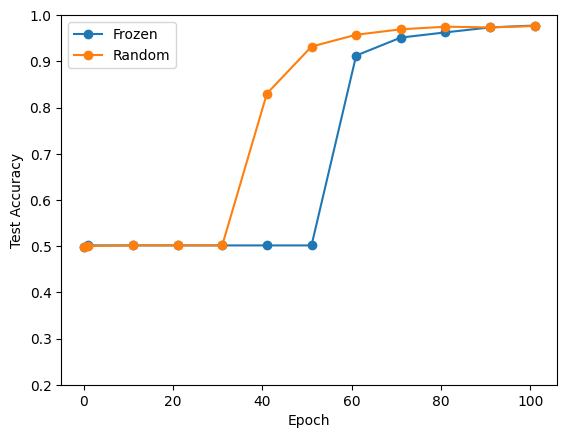

In [96]:
df = target_agent.agent.record.df
test_task = target_task
fig, ax = plt.subplots()
df[df['test_task'] == test_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
random_module_df[random_module_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')                                                                                             
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);